# Imports

Imports and Environment Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

import math

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

# CIFAR10 data

Load and Visualize CIFAR-10 Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

# set batch_size
batch_size = 1

# set number of workers
num_workers = 1

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# 10 classes from CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 106283353.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
t2im = transforms.ToPILImage()
im2t = transforms.PILToTensor()

torch.Size([1, 3, 32, 32]) horse


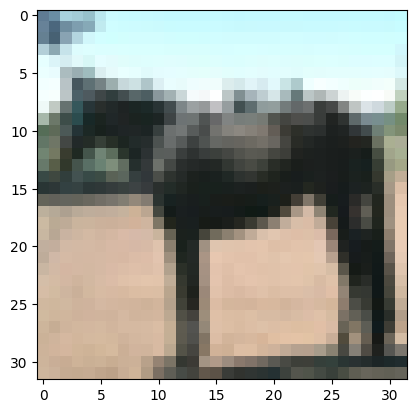

In [4]:
# visualizing sample image

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    plt.imshow(t2im(inputs.squeeze()))
    print(inputs.shape, classes[labels])
    break

# Load SAM

Environment Setup for using SAM

In [5]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-hy3c9i63
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-hy3c9i63
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=2393032382e68889ab9aa50cbb4646c314386768c70347337e204d269a951c39
  Stored in directory: /tmp/pip-ephem-wheel-cache-t4ihw_m6/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-01-21 21:41:02--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163

In [6]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=8b224efd10e55c9914b9307060c718c706d81e9203714d032f7425d0babd83b3
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from google.colab.patches import cv2_imshow
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [8]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

sam = sam_model_registry["vit_h"](checkpoint="/content/sam_vit_h_4b8939.pth")
sam.to(device)

# sam predictor
predictor = SamPredictor(sam)

# sam mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

In [9]:
# function to show annotations
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

## Extract patch-wise embeddings for the image (CIFAR-10)

In [ ]:
embeddings = [] # to store image embeddings
truths = [] # to store ground truth labels


# iterating through all images in the train set
for i, data in enumerate(testloader, 0):
    inputs, labels = data

    # Convert the PyTorch tensor to a NumPy array
    image_np = inputs.squeeze().numpy()

    # Convert from channels-last (C, H, W) to channels-first (H, W, C)
    image_np = np.transpose(image_np, (1, 2, 0))

    # Scale to 0-255
    image_np = (image_np * 255).astype(np.uint8)

    image = image_np

    # generate patch-wise embeddings for the image
    mask_generator.predictor.set_image(image)
    patch_emb = mask_generator.predictor.features
    patch_emb = patch_emb.to("cpu").numpy()
    patch_emb = patch_emb[0].transpose((1,2,0))

    # generate embedding for entire image
    # image embeddding is an average of the patch-wise embeddings
    # each image is represented by a 256-dimensional embedding vector
    img_emb = np.mean(patch_emb, axis=(0, 1))

    embeddings.append(img_emb)
    truths.append(classes[labels])

Saving the embeddings and truths lists to directory

In [ ]:
# Save embeddings to a file
with open('/content/saveperm/embeddings.txt', 'w') as f:
    for emb in embeddings:
        f.write(f'{emb}\n')

# Save truths to a file
with open('/content/saveperm/truths.txt', 'w') as f:
    for truth in truths:
        f.write(f'{truth}\n')

## LDA

In [14]:
# Reading truths from file
def read_classes(file_path):
    classes = []
    with open(file_path, 'r') as file:
        for line in file:
            classes.append(line.strip())
    return classes

truths = read_classes('/content/saveperm/truths.txt')

In [29]:
# Reading embeddings from file
def read_embeddings(file_path):
    embeddings = []
    current_embedding = []
    with open(file_path, 'r') as file:
        for line in file:
            clean_line = line.strip()

            if clean_line.startswith('['):
                clean_line = clean_line[1:]

            elements = clean_line.split()

            if clean_line.endswith(']'):
                elements[-1] = elements[-1].replace(']', '')
                current_embedding.extend([float(e) for e in elements])
                embeddings.append(np.array(current_embedding))
                current_embedding = []
            else:
                current_embedding.extend([float(e) for e in elements])

    return embeddings

embeddings = read_embeddings('/content/saveperm/embeddings.txt')

In [32]:
print(len(embeddings))
print(embeddings[0].shape)
print(len(truths))

10000
(256,)
10000


In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.asarray(embeddings), truths, test_size=0.2, random_state=18)

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

In [34]:
X_train.shape

(8000, 256)

In [35]:
# Fit the LDA model on the training data
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [36]:
# Transform the data using the LDA model
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [37]:
X_train_lda.shape

(8000, 9)

In [38]:
# Train a classifier on the transformed data (you can use any classifier of your choice)
# Here, we'll use a simple logistic regression classifier
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_lda)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.718


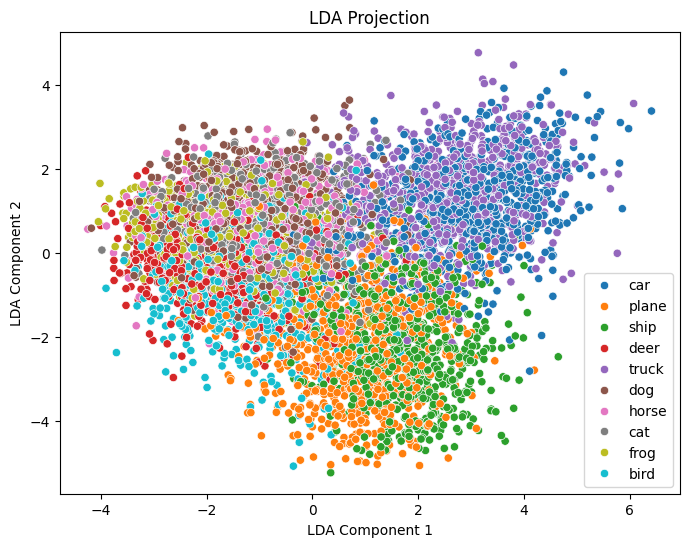

In [39]:
# Assuming X_lda is the transformed data and y is the class labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_lda[:, 0], y=X_train_lda[:, 1], hue=y_train, palette='tab10')
plt.title('LDA Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

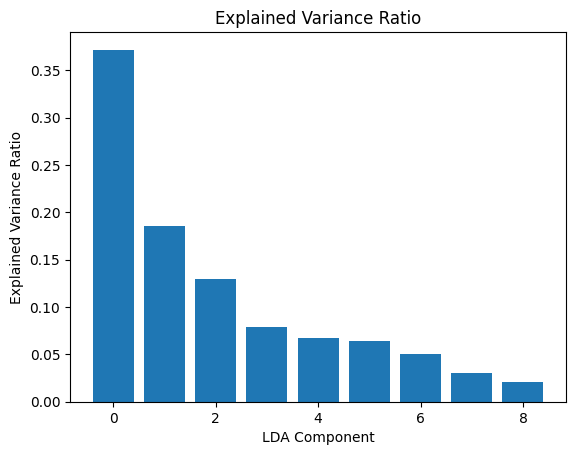

In [41]:
plt.bar(range(len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.xlabel('LDA Component')
plt.ylabel('Explained Variance Ratio')
plt.show()